1 · Fetch the data from kagglle

In [2]:
# Create the .kaggle folder (if not present) **inside this notebook runtime**:
import os, pathlib, json, shutil, getpass

home = pathlib.Path.home()
kag_dir = home / ".kaggle"
kag_dir.mkdir(exist_ok=True)

# If your kaggle.json is already on disk, copy it once.
# Change the source path below if you saved it elsewhere.
src = r"C:\Users\sahan\Desktop\MYProjects\Neonatal_jaundice_detection\.kaggle\kaggle.json"  
shutil.copy(src, kag_dir / "kaggle.json")

# Good hygiene:  read/write for you, nothing for others
os.chmod(kag_dir / "kaggle.json", 0o600)

# Verify the token file exists
print("kaggle.json present:", (kag_dir / "kaggle.json").exists())


kaggle.json present: True


2. Download and unzip

In [3]:
# 1) download data set
!kaggle datasets download -d aiolapo/jaundice-image-data -p ./data -q

# 2) extract with Python's standard library
import zipfile, pathlib, os, itertools

zip_path = pathlib.Path("data") / "jaundice-image-data.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("data")

# 3) quick directory peek – show first few sub-folders/files
def tree_preview(root="data", max_lines=20):
    lines_shown = 0
    for dirpath, dirnames, filenames in os.walk(root):
        indent = " " * (dirpath.replace(root, "").count(os.sep) * 2)
        print(f"{indent}{pathlib.Path(dirpath).name}/")
        lines_shown += 1
        for f in filenames[:5]:
            print(f"{indent}  {f}")
            lines_shown += 1
        if lines_shown >= max_lines:
            return
tree_preview()


Dataset URL: https://www.kaggle.com/datasets/aiolapo/jaundice-image-data
License(s): MIT
data/
  jaundice-image-data.zip
  jaundice/
    jaundice (1).jpg
    jaundice (10).jpg
    jaundice (100).jpg
    jaundice (101).jpg
    jaundice (102).jpg
  normal/
    normal (1).jpg
    normal (1000).jpg
    normal (1001).jpg
    normal (1002).jpg
    normal (1003).jpg


3 · Basic EDA (exploratory data analysis)

Normal: 560 images
Jaundice: 200 images


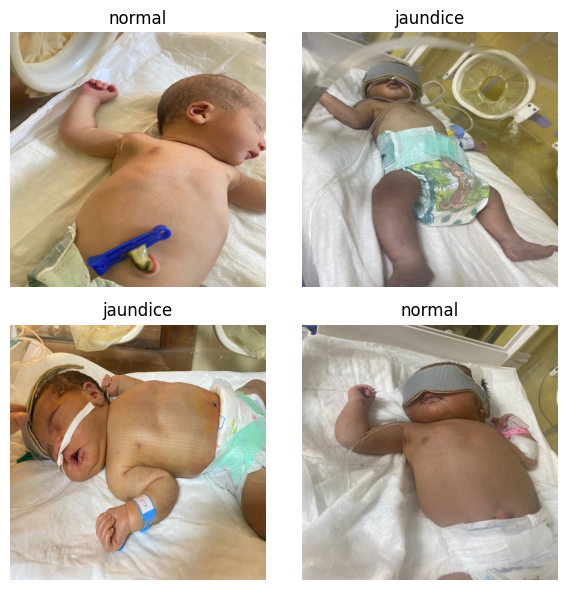

In [4]:

import cv2, random, matplotlib.pyplot as plt, pathlib
root = pathlib.Path("data")

# Count images
for cls in ("Normal","Jaundice"):
    n = len(list((root/cls).glob("*")))
    print(f"{cls}: {n} images")

# Peek at a few randomly chosen pictures
sample_files = random.sample(list(root.rglob("*.*")), 4)
plt.figure(figsize=(6,6))
for i,f in enumerate(sample_files,1):
    img = cv2.cvtColor(cv2.imread(str(f)), cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,i); plt.imshow(img); plt.title(f.parent.name); plt.axis("off")
plt.tight_layout(); plt.show()


4. Define transformations & Dataset/DataLoader

In [5]:
%pip install --upgrade albumentations albucore

import torch, albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import numpy as np

IMG_SIZE = 224
MEAN, STD = (0.485,0.456,0.406), (0.229,0.224,0.225)

train_tfms = A.Compose([
    A.SmallestMaxSize(IMG_SIZE),
    A.RandomCrop(IMG_SIZE, IMG_SIZE),
    A.Rotate(limit=15, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(0.2,0.2,p=0.3),
    A.Normalize(MEAN, STD),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.SmallestMaxSize(IMG_SIZE),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(MEAN, STD),
    ToTensorV2()
])

class EyeJaundiceSet(Dataset):
    def __init__(self, root="data", split="train", val_ratio=0.15, seed=42):
        root = pathlib.Path(root)
        items=[]
        for label,cls in enumerate(("Normal","Jaundice")):
            for p in (root/cls).glob("*"):
                items.append((p, label))
        random.Random(seed).shuffle(items)
        n_val = int(len(items)*val_ratio)
        self.items = items[n_val:] if split=="train" else items[:n_val]
        self.tfms  = train_tfms if split=="train" else val_tfms
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        img = self.tfms(image=img)["image"]
        return img, torch.tensor(label, dtype=torch.float32)

train_ds, val_ds = EyeJaundiceSet(split="train"), EyeJaundiceSet(split="val")
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False)
print(len(train_ds), "train samples —", len(val_ds), "val samples")


Note: you may need to restart the kernel to use updated packages.
646 train samples — 114 val samples


5. Build the model (transfer-learning)

In [6]:
import torchvision.models as models
import torch.nn as nn, torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.mobilenet_v3_small(weights="MobileNet_V3_Small_Weights.DEFAULT")
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.3)


6. Training loop

In [7]:
# ------------------------------------------------------------------
# one-time install for a nicer progress bar (safe to re-run)
%pip install -q ipywidgets

from tqdm.auto import tqdm               # never calls jupyter-nbextension
from torch.utils.data import DataLoader  # needed to rebuild loaders

# ── REBUILD LOADERS WITH A SINGLE WORKER (Windows-safe) ───────────
# train_ds and val_ds were created in earlier cells; we reuse them here.
train_dl = DataLoader(train_ds,
                      batch_size=32,
                      shuffle=True,
                      num_workers=0,     # <- THE KEY FIX
                      pin_memory=True)

val_dl   = DataLoader(val_ds,
                      batch_size=32,
                      shuffle=False,
                      num_workers=0,
                      pin_memory=True)

# ── TRAIN / EVAL HELPER ───────────────────────────────────────────
def epoch_pass(dataloader, train=True):
    model.train(train)
    loss_sum = tp = tn = fp = fn = 0
    for x, y in tqdm(dataloader, leave=False):
        x, y = x.to(device), y.to(device).unsqueeze(1)
        logits = model(x)
        loss   = criterion(logits, y)
        if train:
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        loss_sum += loss.item() * len(x)
        preds = (torch.sigmoid(logits) > 0.5).int()
        tp += ((preds == 1) & (y == 1)).sum().item()
        tn += ((preds == 0) & (y == 0)).sum().item()
        fp += ((preds == 1) & (y == 0)).sum().item()
        fn += ((preds == 0) & (y == 1)).sum().item()
    n     = len(dataloader.dataset)
    acc   = (tp + tn) / n
    sens  = tp / (tp + fn + 1e-9)
    spec  = tn / (tn + fp + 1e-9)
    return loss_sum / n, acc, sens, spec

# ── MAIN TRAINING LOOP ────────────────────────────────────────────
EPOCHS = 10
for epoch in range(EPOCHS):
    tr_loss, tr_acc, *_            = epoch_pass(train_dl, train=True)
    vl_loss, vl_acc, vl_sens, vl_spec = epoch_pass(val_dl, train=False)
    scheduler.step(vl_loss)
    print(f"{epoch:02d}  train acc {tr_acc:.3f} | "
          f"val acc {vl_acc:.3f}  sens {vl_sens:.3f}  spec {vl_spec:.3f}")
# ------------------------------------------------------------------


Note: you may need to restart the kernel to use updated packages.


c:\Users\sahan\Desktop\MYProjects\Neonatal_jaundice_detection\jaundice-env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

00  train acc 0.800 | val acc 0.649  sens 0.000  spec 1.000


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

01  train acc 0.909 | val acc 0.675  sens 0.075  spec 1.000


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

02  train acc 0.969 | val acc 0.684  sens 0.100  spec 1.000


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

03  train acc 0.966 | val acc 0.816  sens 0.500  spec 0.986


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

04  train acc 0.980 | val acc 0.860  sens 0.775  spec 0.905


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

05  train acc 0.960 | val acc 0.728  sens 0.225  spec 1.000


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

06  train acc 0.960 | val acc 0.763  sens 0.400  spec 0.959


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

07  train acc 0.989 | val acc 0.825  sens 0.775  spec 0.851


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

08  train acc 0.986 | val acc 0.860  sens 0.825  spec 0.878


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

09  train acc 0.994 | val acc 0.886  sens 0.875  spec 0.892


7. Grad-CAM sanity check 

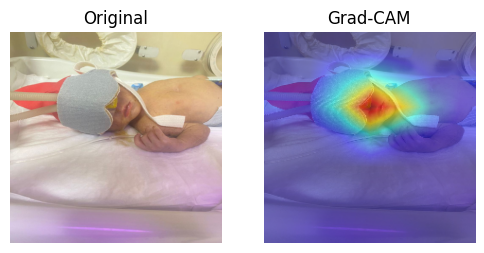

In [8]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np, matplotlib.pyplot as plt, cv2, random, torch

target_layer = model.features[-1]   # last conv layer
cam = GradCAM(model=model, target_layers=[target_layer])

sample_path = random.choice(list((root/"Jaundice").glob("*")))
orig = cv2.imread(str(sample_path))
rgb  = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
prep = val_tfms(image=rgb)["image"].unsqueeze(0).to(device)

grayscale = cam(prep)[0]     # CAM heat-map
# Resize rgb to match CAM shape (224x224)
rgb_resized = cv2.resize(rgb, (grayscale.shape[1], grayscale.shape[0]))
overlay = show_cam_on_image(rgb_resized/255.0, grayscale, use_rgb=True)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM"); plt.axis("off")
plt.show()


8. Save & export model

In [9]:
%pip install onnx

torch.save(model.state_dict(), "jaundice_mobilenetv3.pt")

# Optional: export to ONNX for mobile / C++ / TF-Lite
dummy = torch.randn(1,3,IMG_SIZE,IMG_SIZE).to(device)
torch.onnx.export(model, dummy, "jaundice_mobilenetv3.onnx",
                  input_names=["input"], output_names=["logits"],
                  opset_version=17)
print("Saved weights and ONNX graph.")


Note: you may need to restart the kernel to use updated packages.
Saved weights and ONNX graph.


In [10]:
#%pip install -q onnxruntime opencv-python


In [11]:
# import onnxruntime as ort
# import numpy as np, cv2, pathlib, math

# MODEL_PATH = pathlib.Path("jaundice_mobilenetv3.onnx")   # adjust if you renamed it
# session = ort.InferenceSession(
#     MODEL_PATH.as_posix(),
#     providers=["CPUExecutionProvider"])          # GPU EP works too if available
# input_name  = session.get_inputs()[0].name       # normally "input"


In [12]:
# IMG_SIZE = 224
# MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1, 3, 1, 1)
# STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 3, 1, 1)

# def preprocess_bgr(img_bgr: np.ndarray) -> np.ndarray:
#     """Resize so the shorter side = 224, center-crop 224×224, normalize."""
#     rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

#     h, w = rgb.shape[:2]
#     scale = IMG_SIZE / min(h, w)
#     new_w, new_h = int(w * scale), int(h * scale)
#     resized = cv2.resize(rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

#     # centre crop
#     x0 = (new_w - IMG_SIZE) // 2
#     y0 = (new_h - IMG_SIZE) // 2
#     crop = resized[y0:y0+IMG_SIZE, x0:x0+IMG_SIZE]

#     x = crop.astype(np.float32) / 255.0                         # 0-1
#     x = (x.transpose(2, 0, 1)[None] - MEAN) / STD               # 1×3×224×224
#     return x.astype(np.float32)


In [13]:
# def jaundice_prob(img_bgr: np.ndarray) -> float:
#     """Return p(jaundice) between 0 and 1."""
#     x = preprocess_bgr(img_bgr)
#     logits = session.run(None, {input_name: x})[0]
#     # binary-sigmoid output → probability
#     prob = 1.0 / (1.0 + math.exp(-float(logits[0, 0])))
#     return prob


In [14]:
# cap = cv2.VideoCapture(0)        # 0 = default webcam
# assert cap.isOpened(), "Camera not found"

# THRESHOLD = 0.50                 # tune to your validation ROC-curve

# while True:
#     ok, frame = cap.read()
#     if not ok:
#         break

#     p = jaundice_prob(frame)
#     label = "JAUNDICE" if p >= THRESHOLD else "normal"
#     colour = (0,0,255) if label=="JAUNDICE" else (0,255,0)

#     cv2.putText(frame, f"{label}  {p:.2f}",
#                 (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
#                 1.0, colour, 2, cv2.LINE_AA)

#     cv2.imshow("Neonatal jaundice screen", frame)
#     if cv2.waitKey(1) & 0xFF == 27:       # Esc
#         break

# cap.release()
# cv2.destroyAllWindows()
